In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from PIL import Image

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf 
from tensorflow.keras.layers  import Dense ,Conv2D ,Activation , Dropout , BatchNormalization , ReLU , MaxPooling2D , Flatten 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau , ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

# GPU Configuration for RTX 3070
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Configure GPU memory growth to avoid OOM errors 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) configured: {[gpu.name for gpu in gpus]}")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  0


In [3]:
data_dir = r"E:\5 semester\machine learning\lab\lab final\final\plantvillage dataset\color"
label = []
image_path = []
folds = os.listdir(data_dir)
for fold in folds :
    folder_path = os.path.join(data_dir , fold)
    imgs = os.listdir(folder_path)
    for img in imgs : 
        img_path = os.path.join(folder_path , img)
        label.append(fold)
        image_path.append(img_path)
print("Total images:", len(image_path))
print("Total labels:", len(label))

Total images: 54305
Total labels: 54305


In [4]:
paths_df = pd.Series(image_path)
label_df = pd.Series(label)

data = pd.DataFrame(
    {
        "imagepaths" :paths_df,
        "label" : label_df
    }
)

In [5]:
data.head()

,imagepaths,label
0,E:\5 semester\machine learning\lab\lab final\f...,Apple___Apple_scab
1,E:\5 semester\machine learning\lab\lab final\f...,Apple___Apple_scab
2,E:\5 semester\machine learning\lab\lab final\f...,Apple___Apple_scab
3,E:\5 semester\machine learning\lab\lab final\f...,Apple___Apple_scab
4,E:\5 semester\machine learning\lab\lab final\f...,Apple___Apple_scab


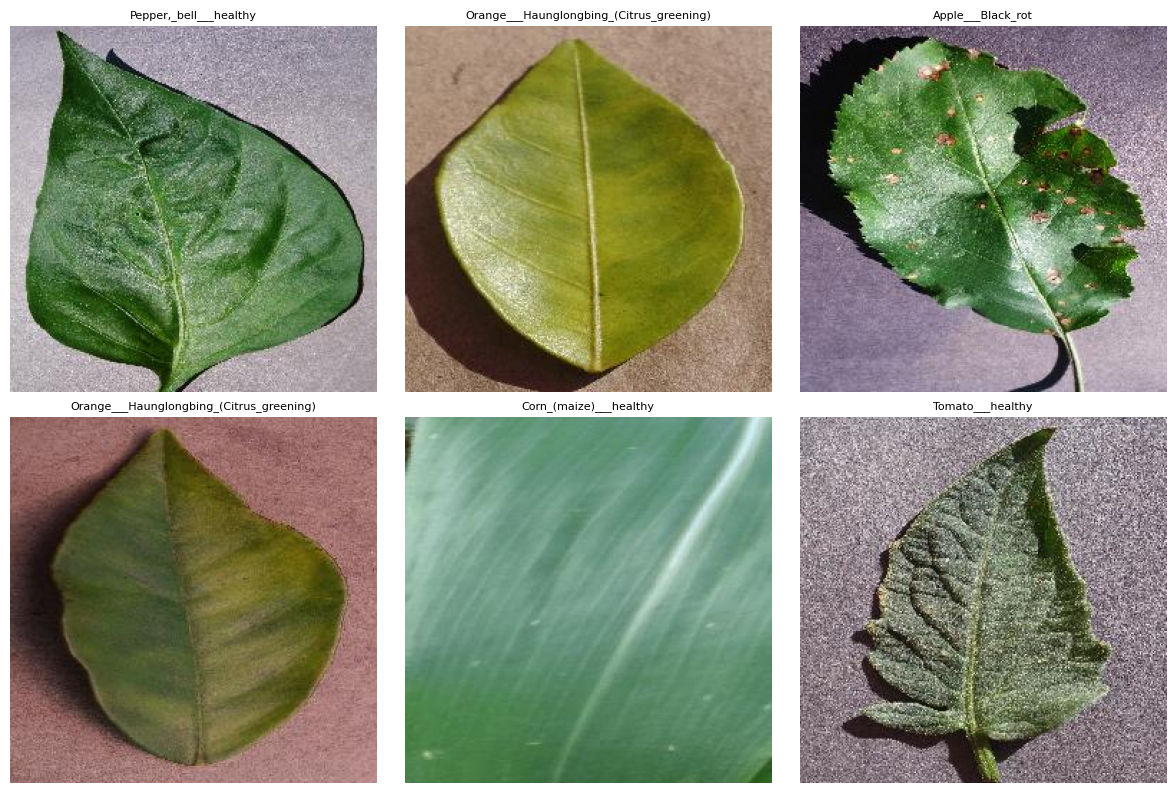

In [6]:
plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    rand_idx = np.random.randint(0, len(data))
    img_path = data.iloc[rand_idx]['imagepaths']
    lbl = data.iloc[rand_idx]['label']
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title(lbl, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

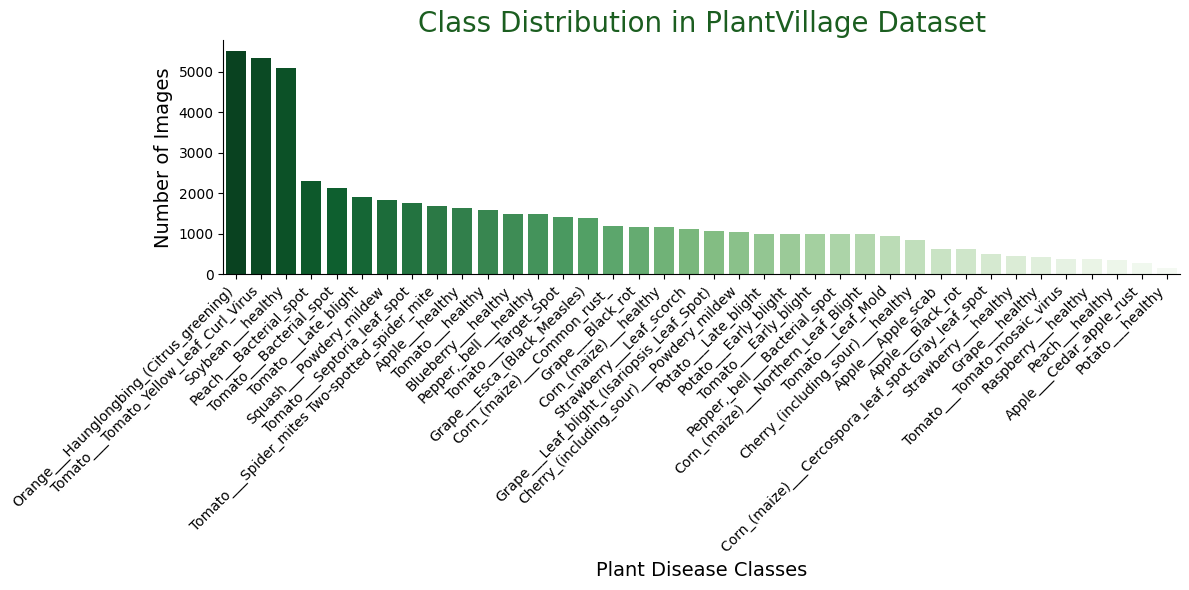

In [7]:
label_counts = data.label.value_counts().reset_index()
label_counts.columns = ['Label', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(
    data=label_counts,
    x="Label",
    y="Count",
    palette="Greens_r"  
)
plt.title("Class Distribution in PlantVillage Dataset", fontsize=20, color="#1b5e20")
plt.xlabel("Plant Disease Classes", fontsize=14)
plt.ylabel("Number of Images", fontsize=14)
plt.xticks(rotation=45, ha="right")
sns.despine()
plt.tight_layout()
plt.show()


## Exploratory Data Analysis

Analyzing RGB color distributions...


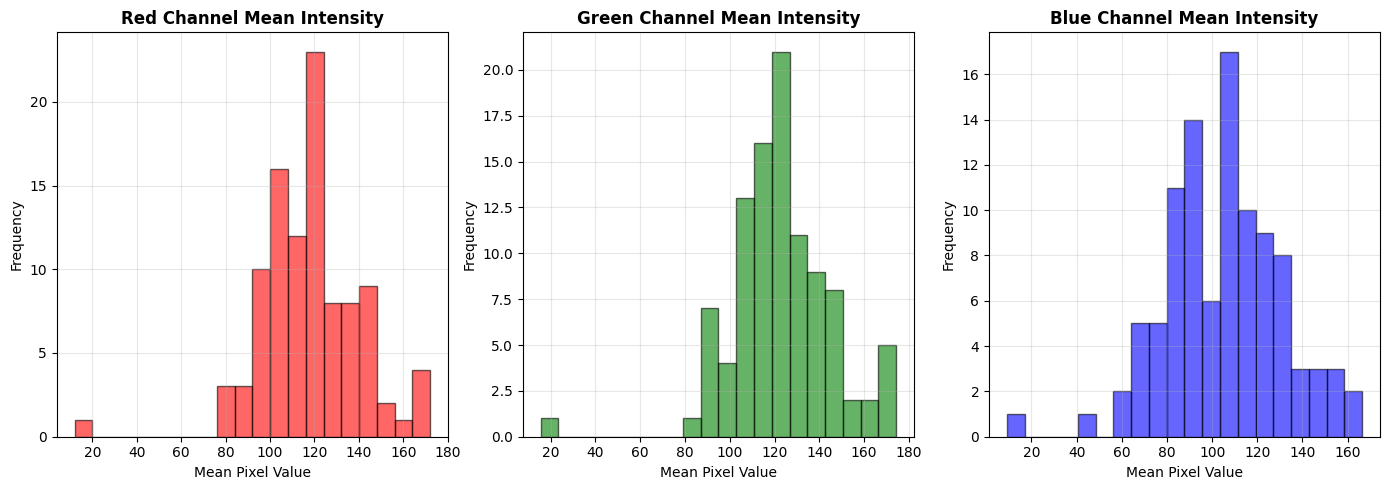


Average RGB values across 100 sample images:
Red:   117.98
Green: 122.64
Blue:  104.47


In [8]:
# Color channel analysis for sample images
print("Analyzing RGB color distributions...")
sample_size = 100
sample_indices = np.random.choice(len(data), sample_size, replace=False)

red_means = []
green_means = []
blue_means = []

for idx in sample_indices:
    img_path = data.iloc[idx]['imagepaths']
    try:
        img = Image.open(img_path)
        img_array = np.array(img)
        if len(img_array.shape) == 3 and img_array.shape[2] == 3:
            red_means.append(np.mean(img_array[:,:,0]))
            green_means.append(np.mean(img_array[:,:,1]))
            blue_means.append(np.mean(img_array[:,:,2]))
    except:
        pass

# Plot RGB distribution
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.hist(red_means, bins=20, color='red', alpha=0.6, edgecolor='black')
plt.title('Red Channel Mean Intensity', fontsize=12, fontweight='bold')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(green_means, bins=20, color='green', alpha=0.6, edgecolor='black')
plt.title('Green Channel Mean Intensity', fontsize=12, fontweight='bold')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(blue_means, bins=20, color='blue', alpha=0.6, edgecolor='black')
plt.title('Blue Channel Mean Intensity', fontsize=12, fontweight='bold')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage RGB values across {len(red_means)} sample images:")
print(f"Red:   {np.mean(red_means):.2f}")
print(f"Green: {np.mean(green_means):.2f}")
print(f"Blue:  {np.mean(blue_means):.2f}")

In [9]:
# Analyze image dimensions and properties
print("Analyzing sample images for properties...")
sample_indices = np.random.choice(len(data), min(500, len(data)), replace=False)

widths = []
heights = []
aspect_ratios = []
file_sizes = []

for idx in sample_indices:
    img_path = data.iloc[idx]['imagepaths']
    try:
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)
        file_sizes.append(os.path.getsize(img_path) / 1024)  # KB
    except:
        pass

print(f"\nImage Properties Analysis (Sample of {len(widths)} images):")
print(f"Average Width: {np.mean(widths):.0f} px")
print(f"Average Height: {np.mean(heights):.0f} px")
print(f"Average Aspect Ratio: {np.mean(aspect_ratios):.2f}")
print(f"Average File Size: {np.mean(file_sizes):.2f} KB")

Analyzing sample images for properties...

Image Properties Analysis (Sample of 500 images):
Average Width: 256 px
Average Height: 256 px
Average Aspect Ratio: 1.00
Average File Size: 15.38 KB


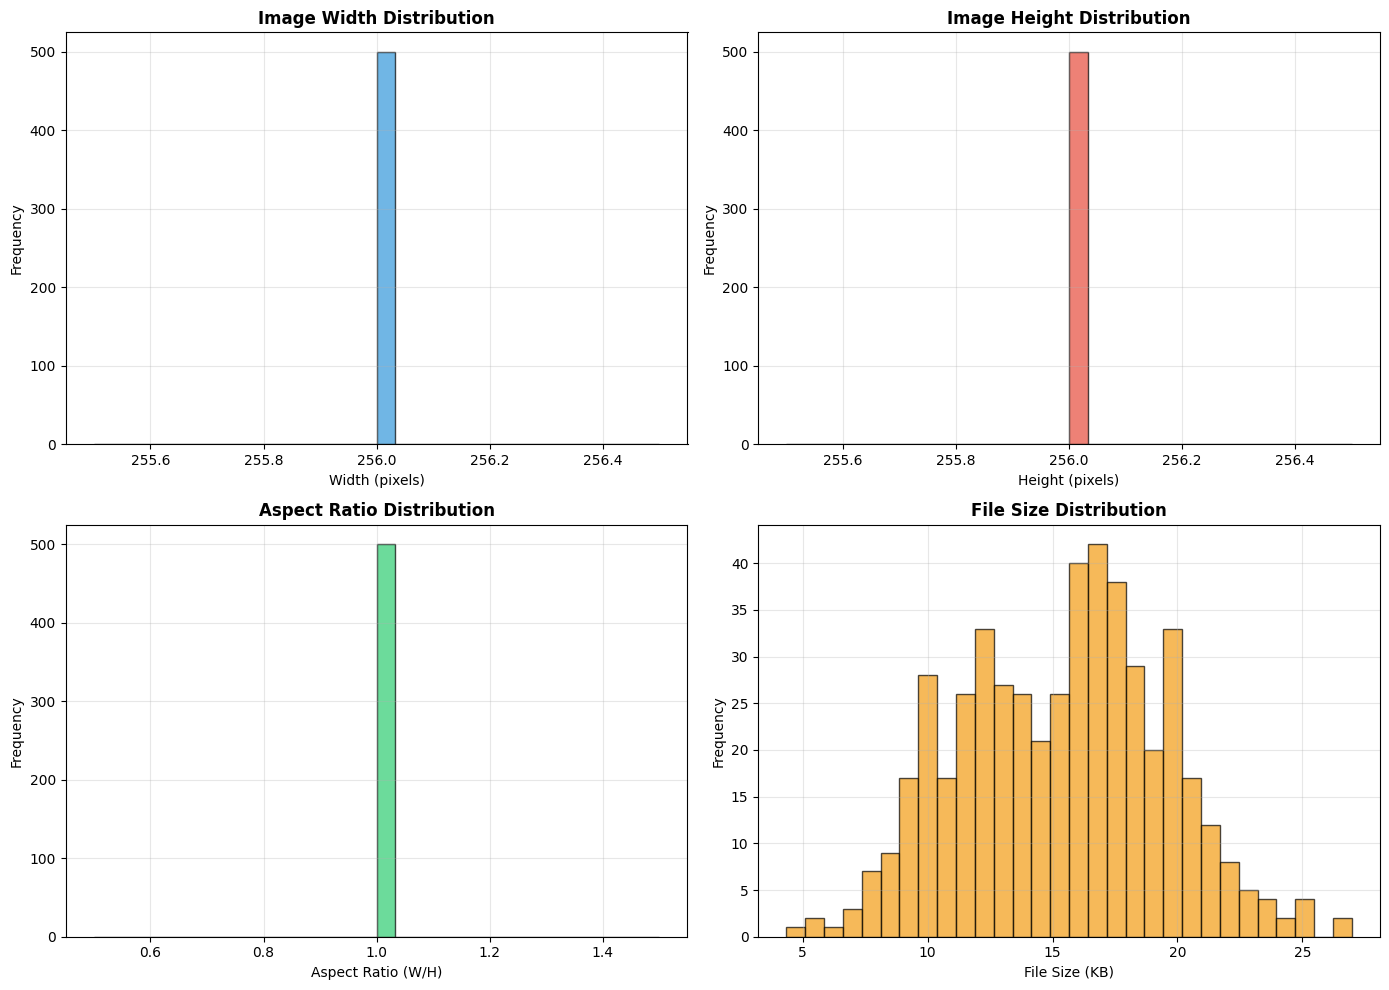

In [10]:
# Visualize image properties distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(widths, bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Image Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(alpha=0.3)

axes[0, 1].hist(heights, bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Image Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(aspect_ratios, bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (W/H)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].hist(file_sizes, bins=30, color='#f39c12', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('File Size Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('File Size (KB)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
train_data, damy_data = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['label'], random_state=42)
valid_data, test_data = train_test_split(damy_data, test_size=0.5, shuffle=True, stratify=damy_data['label'], random_state=42)

In [26]:
print(len(train_data.label.value_counts()))
print(len(test_data.label.value_counts()))
print(len(valid_data.label.value_counts()))

38
38
38


In [27]:
image_size = 224
batch_size = 32 
channel = 3 

In [28]:
train_datagen = ImageDataGenerator(
    rescale = 1./255 , 
    rotation_range=40,
    width_shift_range = 0.2 , 
    height_shift_range = 0.2 , 
    shear_range = 0.2 , 
    zoom_range = 0.2 , 
    horizontal_flip=True,
     fill_mode='nearest'
)
test_datagen=ImageDataGenerator(rescale=1./255,)

In [29]:
train_gen=train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='imagepaths',
    y_col='label',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(image_size,image_size),
    shuffle=True
)


Found 43444 validated image filenames belonging to 38 classes.


In [30]:
valid_gen=test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='imagepaths',
    y_col='label',
    class_mode='categorical',
    batch_size=batch_size,
    target_size=(image_size,image_size),
    shuffle=False
    
)

Found 5430 validated image filenames belonging to 38 classes.


In [31]:
test_gen=test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='imagepaths',
    y_col='label',
    batch_size=batch_size,
    class_mode='categorical',
    target_size=(image_size,image_size),
    shuffle=False
    
)

Found 5431 validated image filenames belonging to 38 classes.


In [32]:
train_gen.class_indices.items()

dict_items([('Apple___Apple_scab', 0), ('Apple___Black_rot', 1), ('Apple___Cedar_apple_rust', 2), ('Apple___healthy', 3), ('Blueberry___healthy', 4), ('Cherry_(including_sour)___Powdery_mildew', 5), ('Cherry_(including_sour)___healthy', 6), ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 7), ('Corn_(maize)___Common_rust_', 8), ('Corn_(maize)___Northern_Leaf_Blight', 9), ('Corn_(maize)___healthy', 10), ('Grape___Black_rot', 11), ('Grape___Esca_(Black_Measles)', 12), ('Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 13), ('Grape___healthy', 14), ('Orange___Haunglongbing_(Citrus_greening)', 15), ('Peach___Bacterial_spot', 16), ('Peach___healthy', 17), ('Pepper,_bell___Bacterial_spot', 18), ('Pepper,_bell___healthy', 19), ('Potato___Early_blight', 20), ('Potato___Late_blight', 21), ('Potato___healthy', 22), ('Raspberry___healthy', 23), ('Soybean___healthy', 24), ('Squash___Powdery_mildew', 25), ('Strawberry___Leaf_scorch', 26), ('Strawberry___healthy', 27), ('Tomato___Bacterial_spot', 

In [33]:
model = Sequential([
    # Block 1
    Conv2D(32, (3,3), padding='same', input_shape=(image_size, image_size, channel)),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Block 2
    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Block 3
    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    MaxPooling2D((2,2)),
    Dropout(0.2),

    # Fully connected
    Flatten(),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),

    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(len(train_gen.class_indices), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_16 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_17 (Bat  (None, 224, 224, 64)     256       
 chNormalization)                                                
                                                                 
 activation_17 (Activation)  (None, 224, 224, 64)     

In [35]:
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(factor=0.3, patience=2, monitor='val_loss', verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]


In [36]:
history=model.fit(train_gen,epochs=25,validation_data=valid_gen,callbacks=callbacks, verbose=1)

Epoch 1/25
1358/1358 [==============================] - ETA: 0s - loss: 1.4282 - accuracy: 0.6007
Epoch 1: val_loss improved from inf to 2.79314, saving model to best_model.h5
1358/1358 [==============================] - 407s 299ms/step - loss: 1.4282 - accuracy: 0.6007 - val_loss: 2.7931 - val_accuracy: 0.4044 - lr: 0.0010
Epoch 2/25
1358/1358 [==============================] - ETA: 0s - loss: 0.7258 - accuracy: 0.7776
Epoch 2: val_loss improved from 2.79314 to 0.64146, saving model to best_model.h5
1358/1358 [==============================] - 272s 201ms/step - loss: 0.7258 - accuracy: 0.7776 - val_loss: 0.6415 - val_accuracy: 0.7978 - lr: 0.0010
Epoch 3/25
1358/1358 [==============================] - ETA: 0s - loss: 0.5214 - accuracy: 0.8382
Epoch 3: val_loss did not improve from 0.64146
1358/1358 [==============================] - 270s 199ms/step - loss: 0.5214 - accuracy: 0.8382 - val_loss: 2.1420 - val_accuracy: 0.5344 - lr: 0.0010
Epoch 4/25
1358/1358 [===========================

In [37]:
loss_train,accuracy_train=model.evaluate(train_gen)
loss_valid,accuracy_valid=model.evaluate(valid_gen)
loss_test,accuracy_test=model.evaluate(test_gen)

170/170 [==============================] - 37s 220ms/step - loss: 0.2431 - accuracy: 0.9195


In [38]:
print(f'Loss Train: {loss_train},Accuracy Train: {accuracy_train}')
print(f'Loss Valid: {loss_valid},Accuracy Valid: {accuracy_valid}')
print(f'Loss Test: {loss_test},Accuracy Test: {accuracy_test}')

Loss Train: 0.2674630284309387,Accuracy Train: 0.9105745553970337
Loss Valid: 0.23772582411766052,Accuracy Valid: 0.9233886003494263
Loss Test: 0.24313288927078247,Accuracy Test: 0.9195359945297241


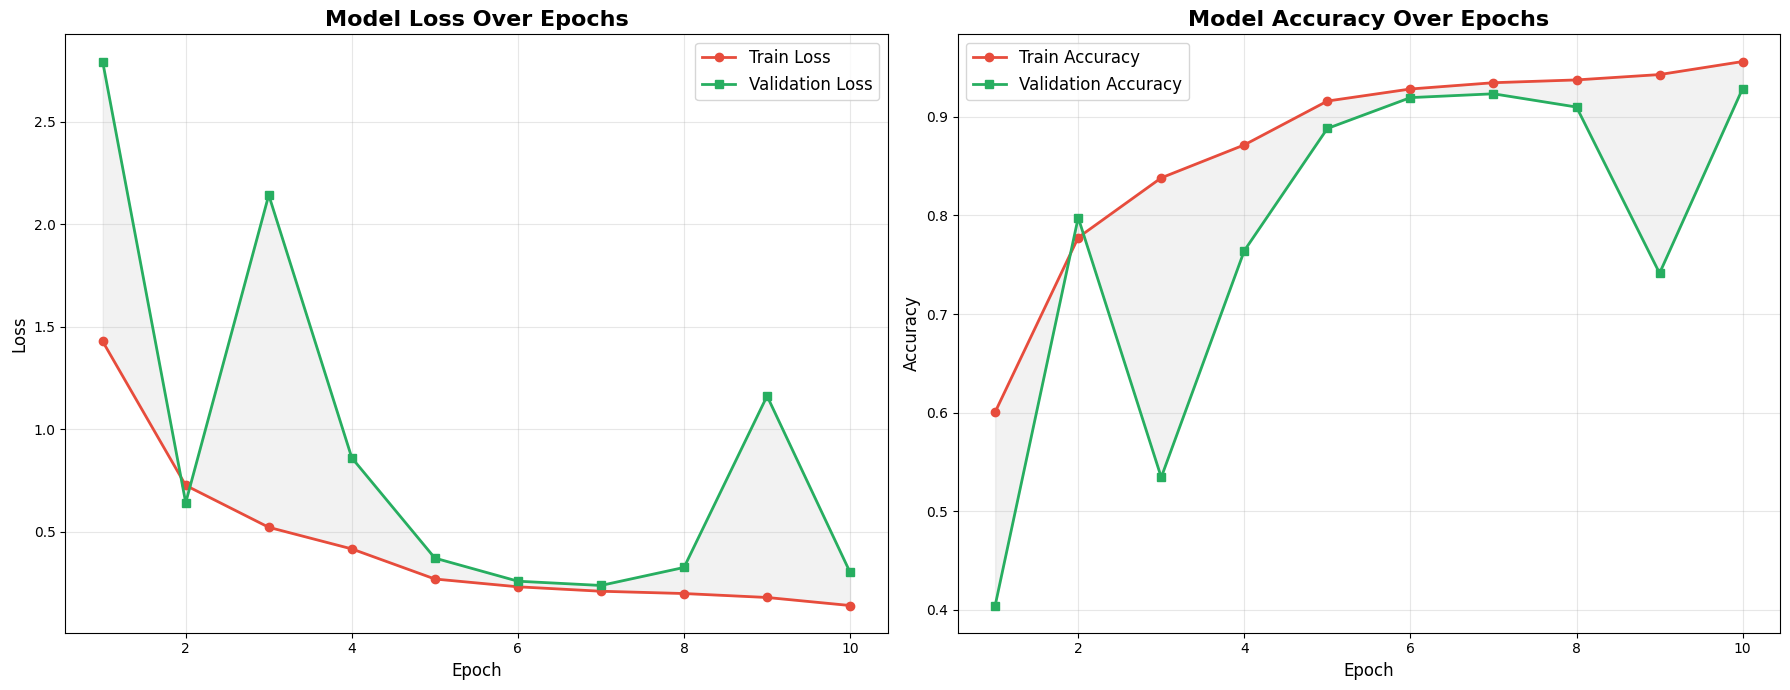

In [39]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = np.arange(1, len(tr_acc) + 1)

plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, color='#E74C3C', linewidth=2, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, color='#27AE60', linewidth=2, marker='s', label='Validation Loss')
plt.fill_between(epochs, val_loss, tr_loss, color='gray', alpha=0.1)  
plt.title('Model Loss Over Epochs', fontsize=16, weight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, color='#E74C3C', linewidth=2, marker='o', label='Train Accuracy')
plt.plot(epochs, val_acc, color='#27AE60', linewidth=2, marker='s', label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs', fontsize=16, weight='bold')
plt.fill_between(epochs, val_acc, tr_acc, color='gray', alpha=0.1)  
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()


In [40]:
def preprocess(img_path, target_size=(224, 224)):
    img = Image.open(img_path)
    resized = img.resize(target_size)
    img_array = np.array(resized)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array.astype('float32') / 255.
    return img_array

In [41]:
def prediction(model,img_path,class_indices):
  preprocessed_img = preprocess(img_path)
  predictions = model.predict(preprocessed_img)
  predicted_class_index = np.argmax(predictions, axis=1)[0]
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [42]:
class_indices = {v: k for k, v in train_gen.class_indices.items()}
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [51]:
image_path = r"D:\archive\plantvillage dataset\color\Grape___Black_rot\1f9d01f0-dde4-49f5-9c27-e87432451556___FAM_B.Rot 3414.JPG"
predicted_class_name = prediction(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 447ms/step
Predicted Class Name: Grape___Black_rot


In [52]:
image_path = r"D:\archive\plantvillage dataset\color\Potato___Late_blight\2c2b39ed-75f9-49f6-a28e-36a2cb608297___RS_LB 2794.JPG"
predicted_class_name = prediction(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 16ms/step
Predicted Class Name: Potato___Late_blight


In [ ]:
plt.figure(figsize=(18,18))

images, labels = next(test_gen)

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i])
    plt.axis('off')

    true_label_idx = np.argmax(labels[i])
    actual = class_indices[true_label_idx]

    preds = model.predict(np.expand_dims(images[i], axis=0), verbose=0)
    pred_label_idx = np.argmax(preds)
    predict = class_indices[pred_label_idx]

    color = 'green' if actual == predict else 'red' #ternnary statement 
    plt.title(f"Actual: {actual}\nPredicted: {predict}", color=color, fontsize=10)

plt.tight_layout()
plt.show()


170/170 ━━━━━━━━━━━━━━━━━━━━ 24s 138ms/step


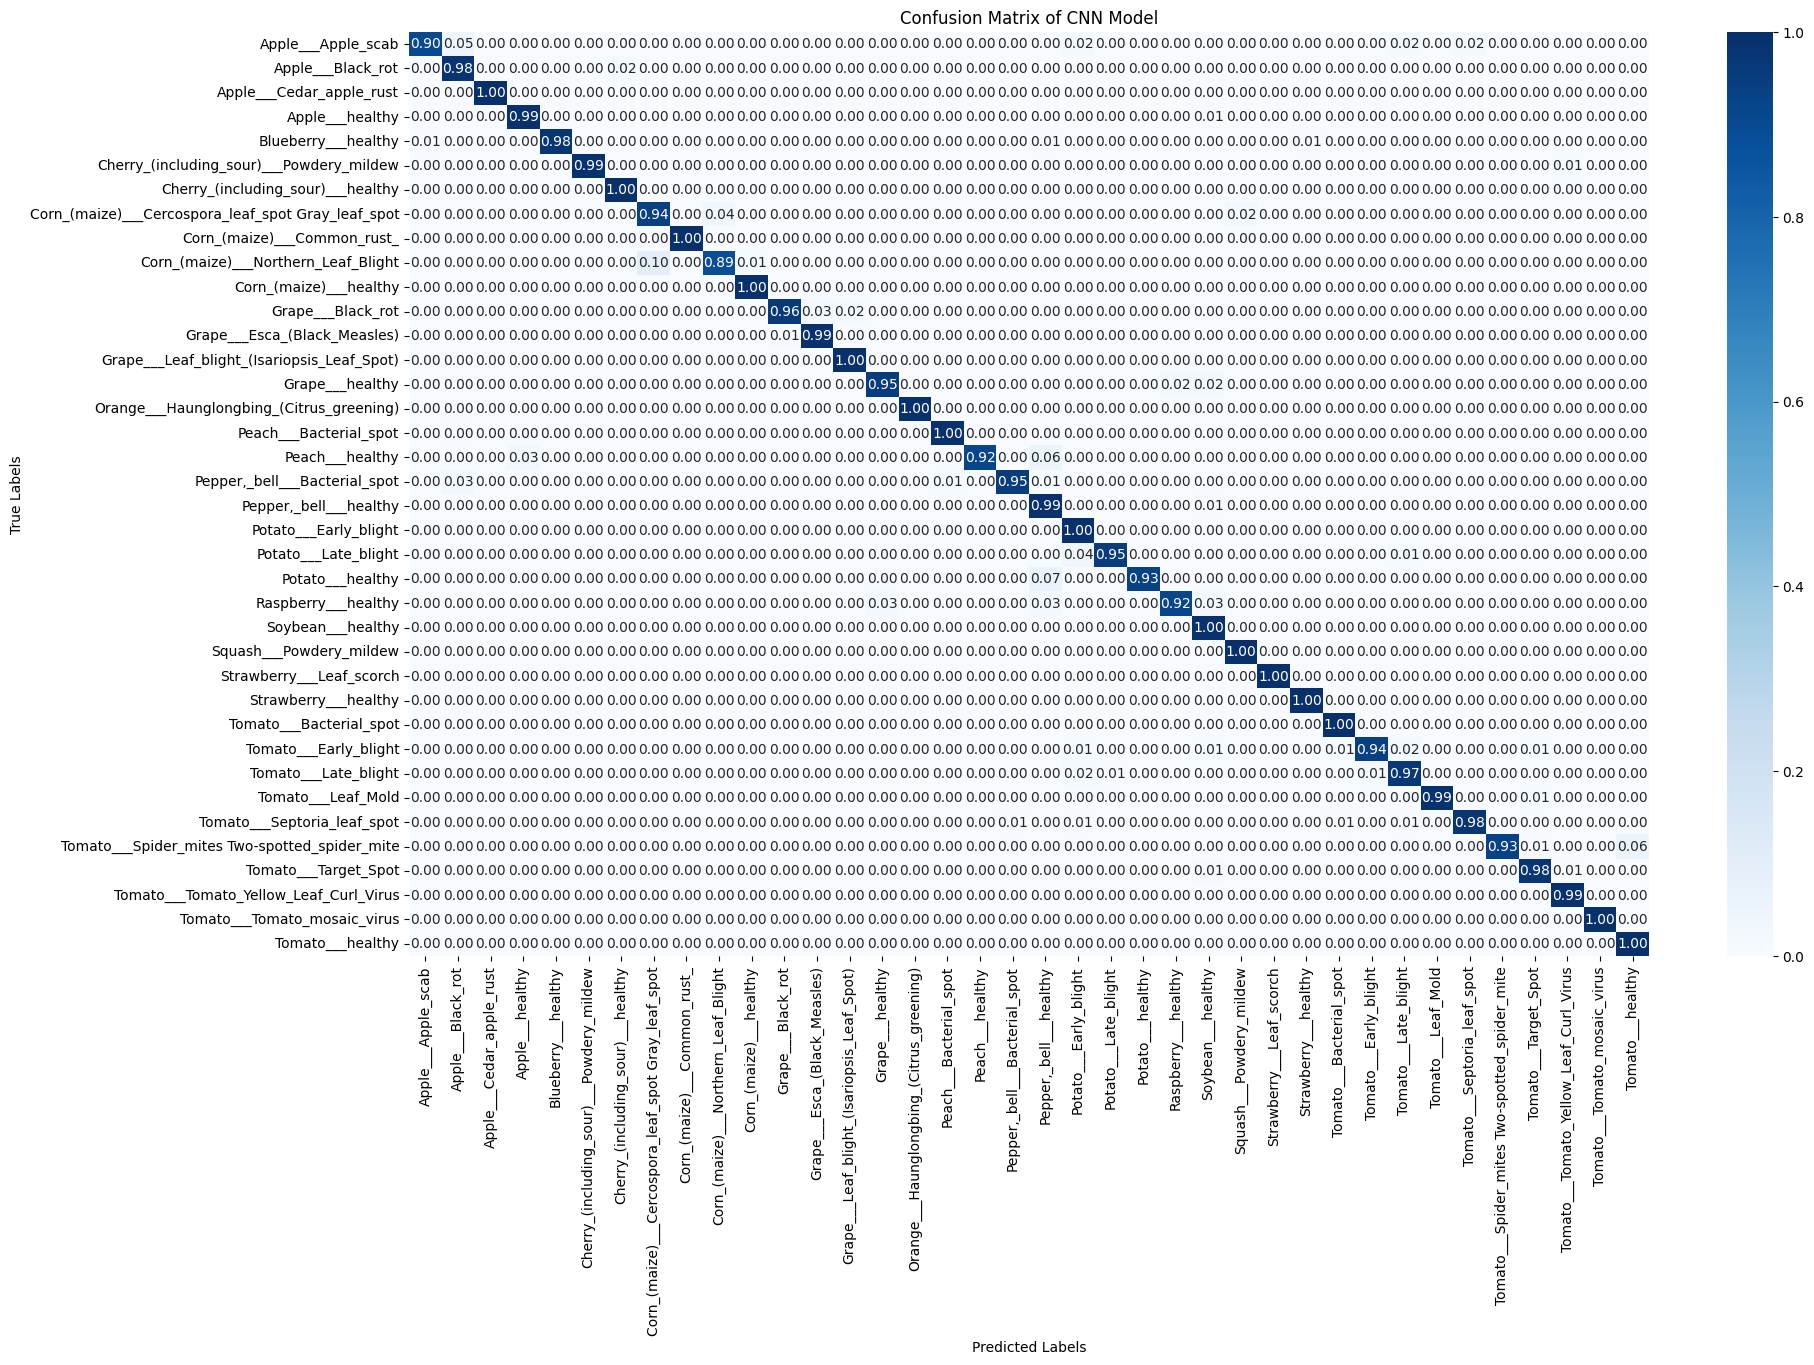


Classification Report:

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.90      0.94        63
                                 Apple___Black_rot       0.90      0.98      0.94        62
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        27
                                   Apple___healthy       0.99      0.99      0.99       165
                               Blueberry___healthy       1.00      0.98      0.99       150
          Cherry_(including_sour)___Powdery_mildew       0.99      0.99      0.99       105
                 Cherry_(including_sour)___healthy       0.99      1.00      0.99        85
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.94      0.88        51
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       120
               Corn_(maize)___Northern_Leaf_Blight    

In [ ]:
y_true = test_gen.classes

y_pred = model.predict(test_gen, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes,normalize='true')

class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(20, 12))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of CNN Model')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_names))
